In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("total-passenger-arrival-2009-2019.csv", parse_dates =["month"], index_col = ["month"])

In [ ]:
df.head()

,value
month,
2009-01-01,3073677
2009-02-01,2558953
2009-03-01,2901885
2009-04-01,2914509
2009-05-01,2787124


In [ ]:
df.tail()

,value
month,
2019-06-01,5816089
2019-07-01,5910782
2019-08-01,5900629
2019-09-01,5469342
2019-10-01,5646643


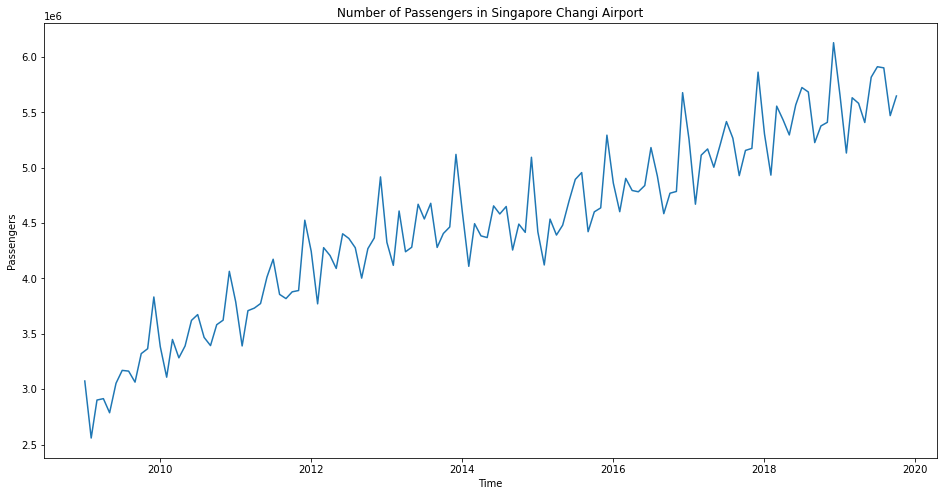

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Number of Passengers in Singapore Changi Airport')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.plot(df.value)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [ ]:
X = df.value
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.581731
p-value: 0.875057
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


p-value > 10%, not reject H0, not stationary

<ipython-input-26-836a7b7bd1ca>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = sm.tsa.seasonal_decompose(df.value,freq=12,model="multiplicative")


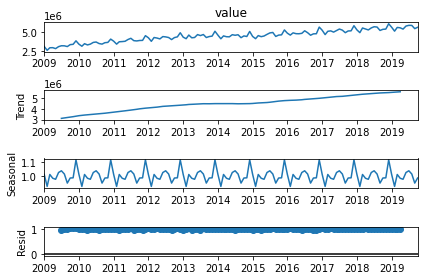

In [ ]:
res = sm.tsa.seasonal_decompose(df.value,freq=12,model="multiplicative")
fig = res.plot()

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

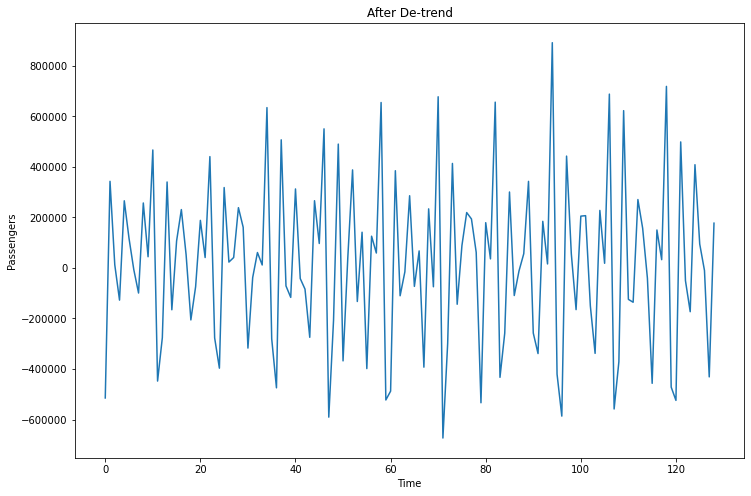

In [ ]:
plt.figure(figsize=(12,8))
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Passengers')
new_ts=difference(df.value)
plt.plot(new_ts)
plt.plot()

In [ ]:
result = adfuller(new_ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.688780
p-value: 0.076000
Critical Values:
	1%: -3.489
	5%: -2.887
	10%: -2.580


p-value < 10%, reject H0, Now stationary

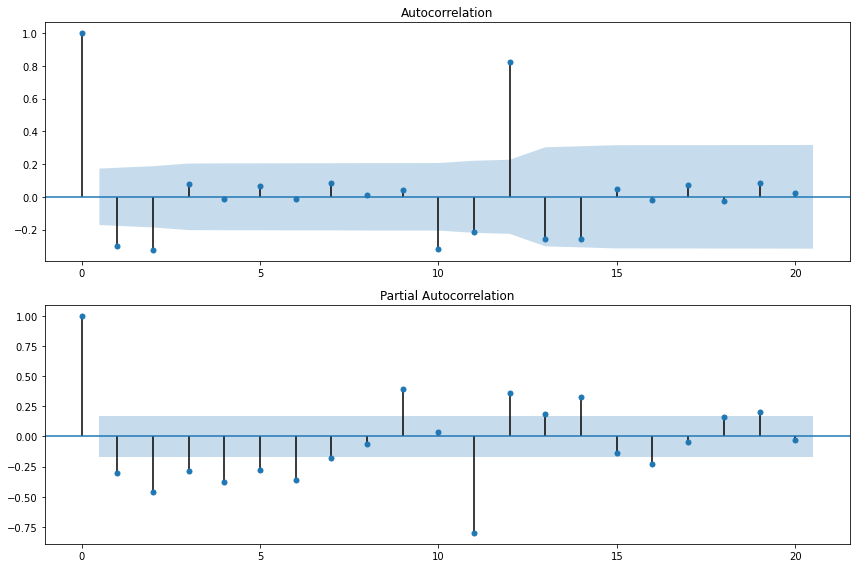

In [ ]:
fig = plt.figure(figsize=(12,8))
#acf
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(new_ts, lags=20,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout();
#pacf
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(new_ts, lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout();

In [ ]:
import itertools
p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4
 
# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
 
for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
     
    try:
        model = sm.tsa.SARIMAX(new_ts, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

D:\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Downloads\Anaconda\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
D:\Downloads\Anaconda\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
D:\Downloads\Anaconda\lib\site-packages\statsmodels\base\model.py:567: Conv

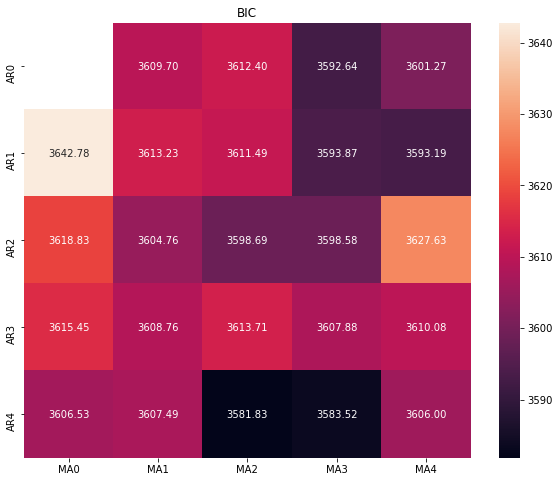

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');

In [ ]:
train_results = sm.tsa.arma_order_select_ic(new_ts, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)
 
print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

D:\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
D:\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:71

AIC (4, 2)
BIC (4, 2)


In [ ]:
df1 = pd.read_csv("total-passenger-arrival-2009-2019_new.csv", parse_dates =["month"], index_col = ["month"])

D:\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


2019-11-01    5.954520e+06
2019-12-01    6.130493e+06
2020-01-01    6.003796e+06
2020-02-01    5.740017e+06
2020-03-01    5.609865e+06
Freq: MS, dtype: float64


D:\Downloads\Anaconda\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


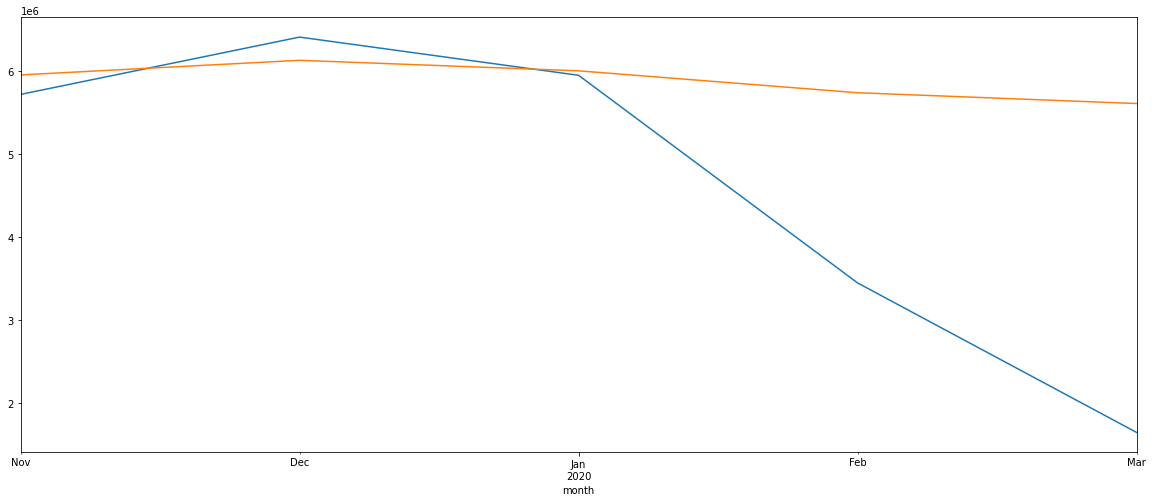

In [ ]:
model = sm.tsa.ARIMA(df.value, order=(4, 0, 2))
results = model.fit()
predict_sunspots = results.predict(start=str('2019-11-01'),end=str('2020-3-01'),dynamic=False)
print(predict_sunspots)
fig, ax = plt.subplots(figsize=(20, 8))
ax = df1[df1.index>="2019-11-01"].value.plot(ax=ax)
predict_sunspots.plot(ax=ax)
plt.show()